In [1]:
import os
os.environ['KAGGLE_USERNAME']="shriharivp"
os.environ['KAGGLE_KEY'] = "adc3764da2eea26146e300d204e47f40"

In [2]:
!kaggle datasets download andrewmvd/pediatric-pneumonia-chest-xray

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.14G/1.14G [00:31<00:00, 40.7MB/s]
100% 1.14G/1.14G [00:31<00:00, 38.6MB/s]


In [3]:
!unzip /content/pediatric-pneumonia-chest-xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0438-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0440-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0441-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0442-

Training on fold 1...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7493 - loss: 2.9192
Epoch 1: val_accuracy improved from -inf to 0.93314, saving model to best_model_fold_1.weights.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.7498 - loss: 2.9129 - val_accuracy: 0.9331 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 2/50
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9101 - loss: 0.5855
Epoch 2: val_accuracy did not improve from 0.93314
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9101 - loss: 0.5850 - val_accuracy: 0.7832 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 3/50
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8954 - loss: 0.4790
Epoch 3: val_accuracy improved from 0.93314 to 0.94174, saving model to best_model_fold_1.weights.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8956 - loss: 0.4785 - val_accuracy: 0.9417 - val_loss: 0.3569 - learning

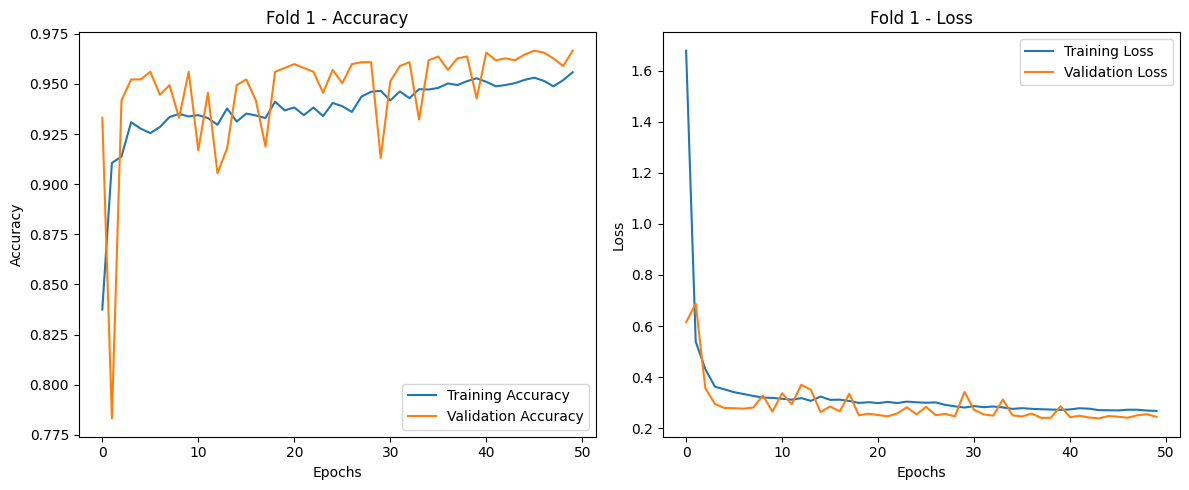

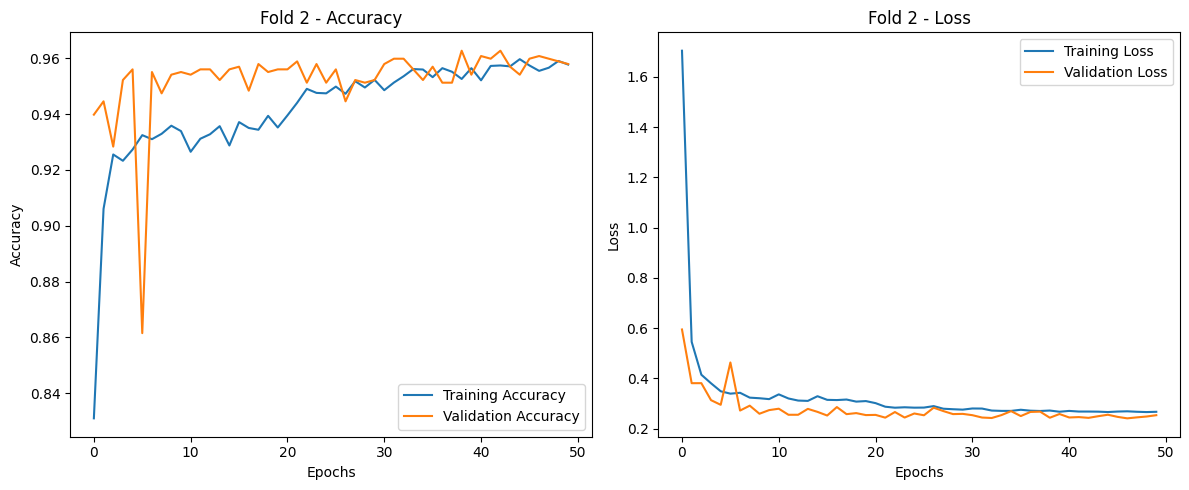

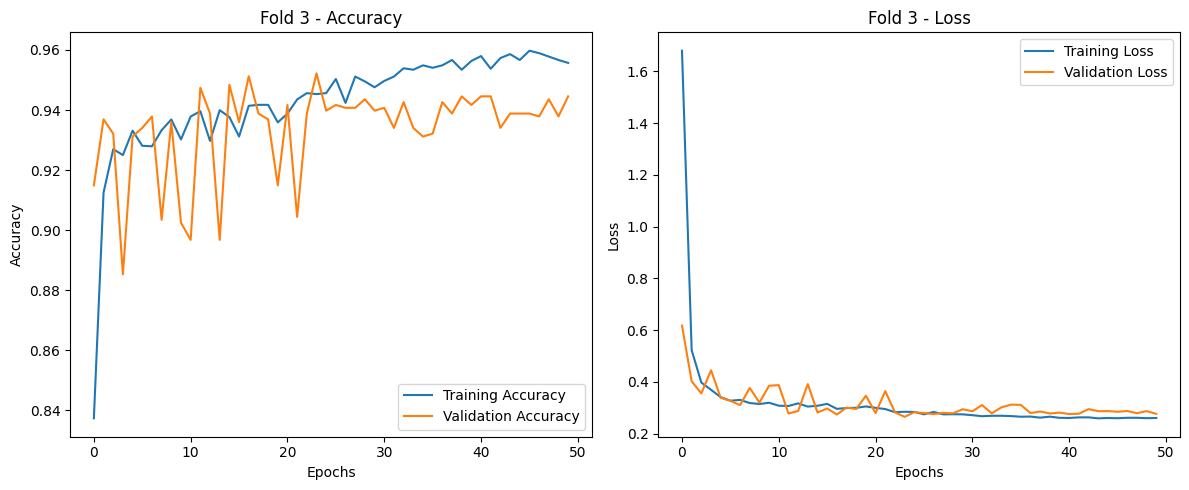

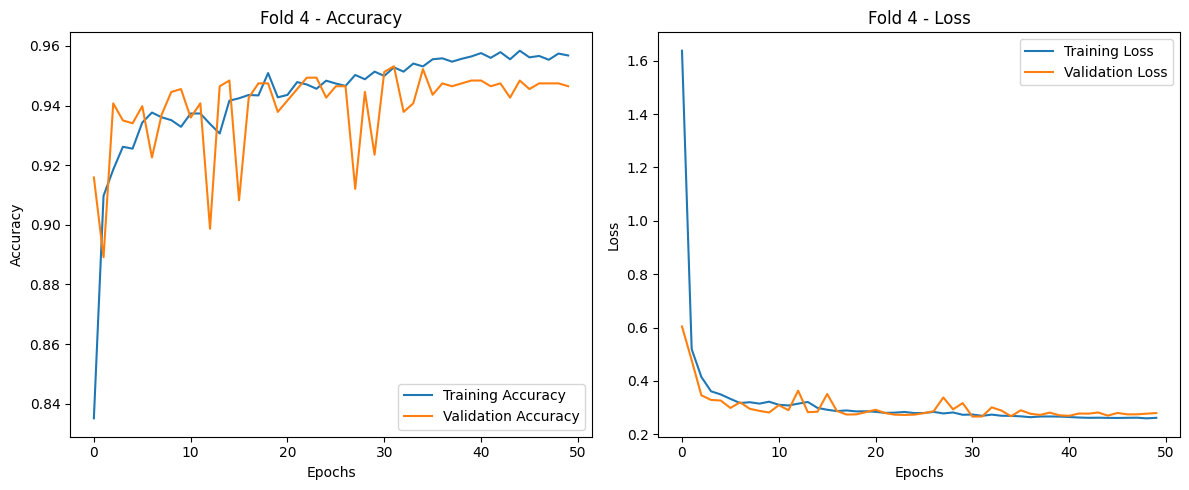

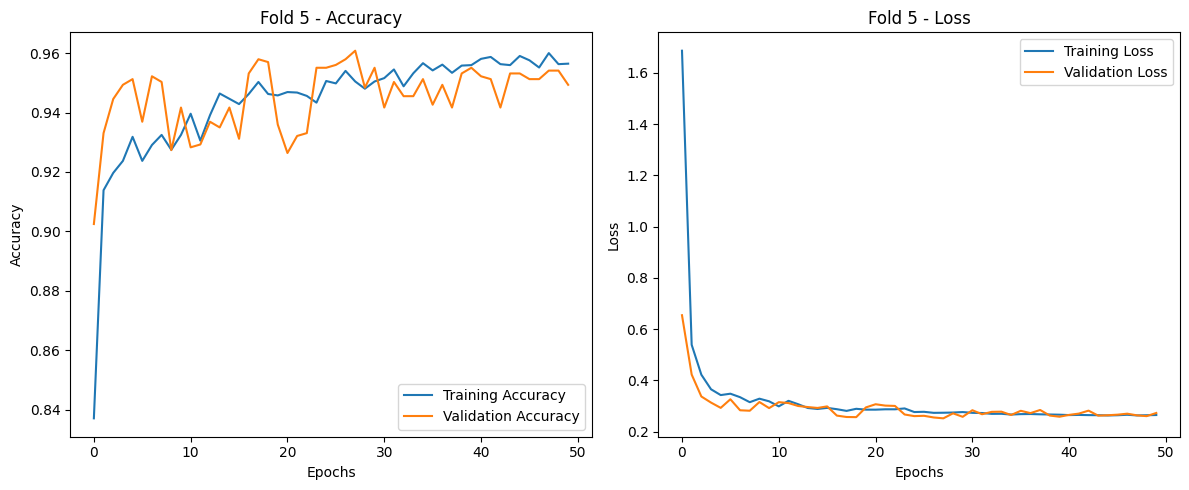

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import tensorflow as tf

# Define dataset path
dataset_path = "/content/Pediatric Chest X-ray Pneumonia"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at: {dataset_path}")

# Parameters
batch_size = 32
img_size = (128, 128)
input_shape = img_size + (3,)
epochs = 50

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load dataset into arrays
train_path = os.path.join(dataset_path, "train")

train_data, train_labels = [], []
for category in ["NORMAL", "PNEUMONIA"]:
    category_path = os.path.join(train_path, category)
    img_files = os.listdir(category_path)

    for img_file in img_files:
        img_path = os.path.join(category_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        train_data.append(img_array)
        train_labels.append(0 if category == "NORMAL" else 1)

# Convert train data and labels to NumPy arrays
train_data = np.array(train_data, dtype='float32') / 255.0  # Normalize images
train_labels = np.array(train_labels)  # Ensure labels are integer array
train_labels = to_categorical(train_labels, num_classes=2)  # One-hot encode labels

# KFold Cross-Validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store Metrics and Histories
fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []
histories = []

# SMOTE and KFold
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_data)):
    print(f"Training on fold {fold + 1}...")

    # Split data
    X_train, X_val = train_data[train_idx], train_data[val_idx]
    y_train, y_val = train_labels[train_idx], train_labels[val_idx]

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for SMOTE
    y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot to labels for SMOTE
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train_labels)

    # Reshape back to image format
    X_train_resampled = X_train_resampled.reshape(-1, img_size[0], img_size[1], 3)
    y_train_resampled = to_categorical(y_train_resampled, num_classes=2)

    # Load Pretrained VGG19
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    # Build Model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    final_output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=final_output)

    # Callbacks
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
    checkpoint = ModelCheckpoint(
        filepath=f'best_model_fold_{fold + 1}.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model
    history = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[lr_schedule, checkpoint],
        verbose=1
    )

    histories.append(history)

    # Evaluate Model
    model.load_weights(f'best_model_fold_{fold + 1}.weights.h5')
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)

    accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
    recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
    f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

    print(f"Fold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

# Summarize Metrics
print("\nCross-Validation Metrics:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average Precision: {np.mean(fold_precisions):.4f}")
print(f"Average Recall: {np.mean(fold_recalls):.4f}")
print(f"Average F1 Score: {np.mean(fold_f1s):.4f}")

# Plot training and validation accuracy and loss for each fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
# Save the final trained model
final_model_path = "/content/best_model_fold_5.weights.h5"
model.save(final_model_path)
print(f"Model saved as {final_model_path}")


Model saved as /content/best_model_fold_5.weights.h5


In [6]:
from google.colab import files

# Download each fold's best model weights
for fold in range(1, 6):  # Assuming 5-fold cross-validation
    weights_filename = f'best_model_fold_{fold}.weights.h5'
    files.download(weights_filename)

files.download("/content/best_model_fold_5.weights.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from google.colab import files
files.download("/content/best_model_fold_5.weights.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>